<a href="https://colab.research.google.com/github/JoshuaOcharan/diabetes-prediction-clustering/blob/main/diabetes_prediction_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.kaggle.com/datasets/mathchi/diabetes-data-set/data

# Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, precision_score, recall_score
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
from scipy.stats import ttest_ind

In [ ]:
df = pd.read_csv('diabetes.csv')

This data comes from the National Institute of Diabetes and Digestive and Kidney Diseases. There are 768 individuals in this dataset with 9 features. Each individuals is a women of at least 21 years old and of Pima Indian Heritage. The data looks at different diagnostic parameters and whether or not the individual has Diabetes.

The 9 features in this dataset are
 - Pregnancies
     - The number of times an individual has been pregnant
 - Glucose
     - Plasma glucose concentration 2 hours after an oral glucose tolerance test
 - BloodPressure
     - Diastolic blood pressure (mm Hg)
 - SkinThickness
     - Triceps skin fold thickness (mm)
 - Insulin
     - 2-hour serum insulin (mu U/ml)
 - BMI
     - Body Mass Index (weight in kg / (height in m)^2)
 - DiabetesPedigreeFunction
     - Function that calculates likelihood of Diabetes based on family history
 - Age
     - Age of the individual (years)
 - Outcome
     - Class variable (0 = non-diabetic, 1 = diabetic)

Our goal is to use these parameters and build machine learning models that predict the likeliness of an individual having Diabetes. Specifically we will be testing a variety of both supervised and unsupervised models like decision trees, random forest, support vector machines, and K-means clustering.

# Cleaning & EDA

## Descriptions

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df.tail()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1
767,1,93,70,31,0,30.4,0.315,23,0


In [ ]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


Glucose, bp, skin thickness, insulin, abd BMI have min of 0. Should not be possible. Basically missing values.

In [ ]:
df.shape

(768, 9)

## Missing Values

In [ ]:
df.isna().sum()
#no missing values

,0
Pregnancies,0
Glucose,0
BloodPressure,0
SkinThickness,0
Insulin,0
BMI,0
DiabetesPedigreeFunction,0
Age,0
Outcome,0


In [ ]:
(df == 0).sum()

,0
Pregnancies,111
Glucose,5
BloodPressure,35
SkinThickness,227
Insulin,374
BMI,11
DiabetesPedigreeFunction,0
Age,0
Outcome,500


In [ ]:
#replace 0s with Na
replace_na_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for c in replace_na_columns:
    df[c] = df[c].replace(0, np.nan)
    print(c,':', df[c].isna().sum())

Glucose : 5
BloodPressure : 35
SkinThickness : 227
Insulin : 374
BMI : 11


Would have liked to have been able to just drop na values, but SkinThickness and Insulin have far too many missing values to just drop.

3 options:

 - Drop entire SkinThickness and Insulin columns (unideal)
 - replace missing values with mean/median values (easy but creates bias)
 - predictive imputation like KNN or regression (more work, but probably best option)

First just perform EDA with missing values.

In [ ]:
missing_percent = df.isna().mean()*100
missing_percent

,0
Pregnancies,0.000000
Glucose,0.651042
BloodPressure,4.557292
SkinThickness,29.557292
Insulin,48.697917
BMI,1.432292
DiabetesPedigreeFunction,0.000000
Age,0.000000
Outcome,0.000000


Text(0, 0.5, 'Percent Missing')

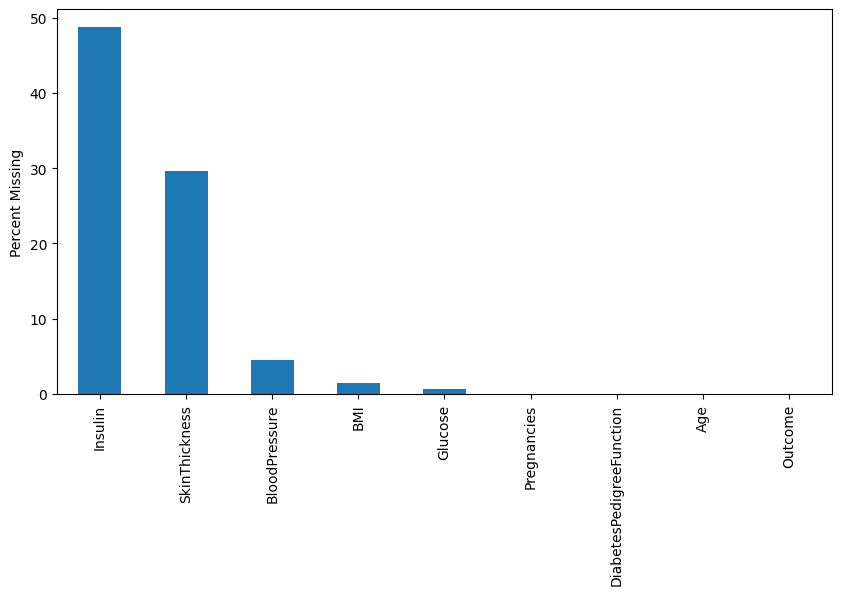

In [ ]:
missing_percent.sort_values(ascending=False).plot(kind="bar", figsize=(10,5))
plt.ylabel('Percent Missing')

##Variables & Visualization

###Pregnancies

<Axes: >

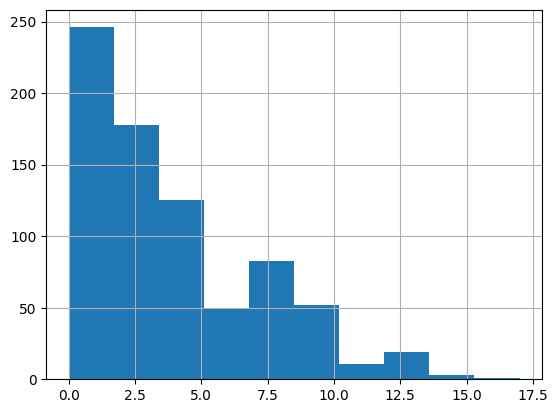

In [ ]:
df['Pregnancies'].hist()

###Glucose

<Axes: >

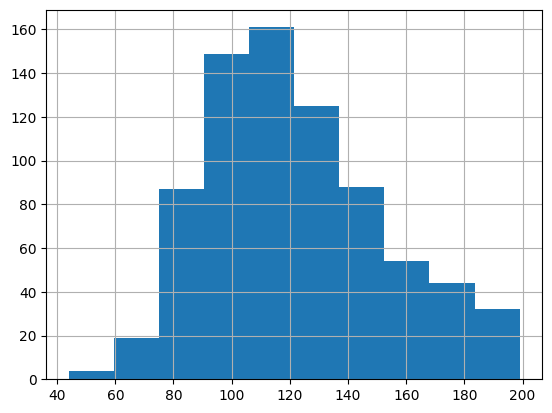

In [ ]:
df['Glucose'].hist()

###Blood Pressure

<Axes: >

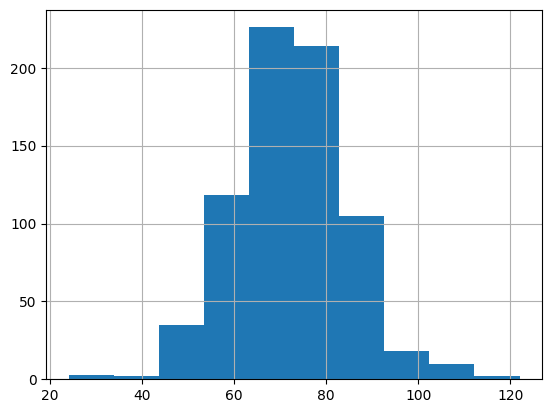

In [ ]:
df['BloodPressure'].hist()

###Skin Thickness

<Axes: >

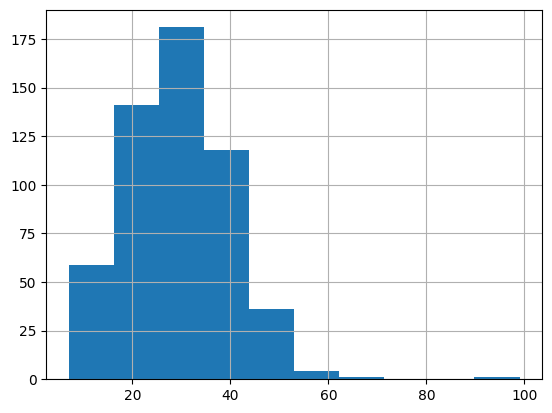

In [ ]:
df['SkinThickness'].hist()

###Insulin

<Axes: >

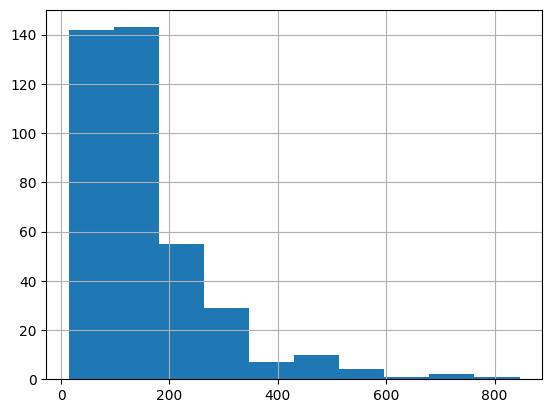

In [ ]:
df['Insulin'].hist()

###DPF

<Axes: >

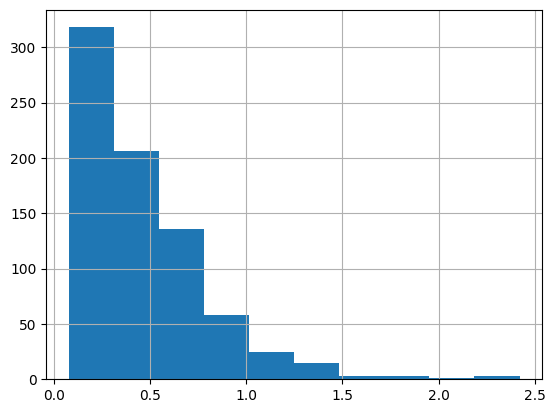

In [ ]:
df['DiabetesPedigreeFunction'].hist()

###Age

<Axes: >

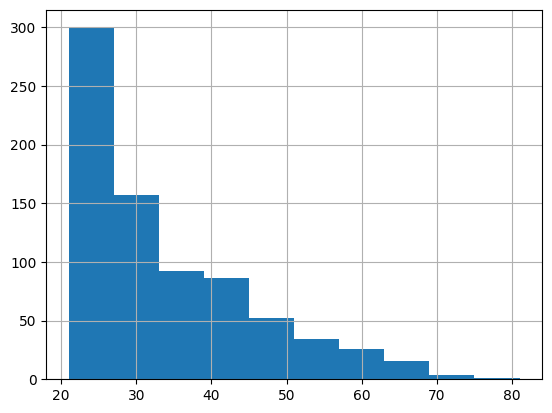

In [ ]:
df['Age'].hist()

###Outcome

<Axes: xlabel='Outcome'>

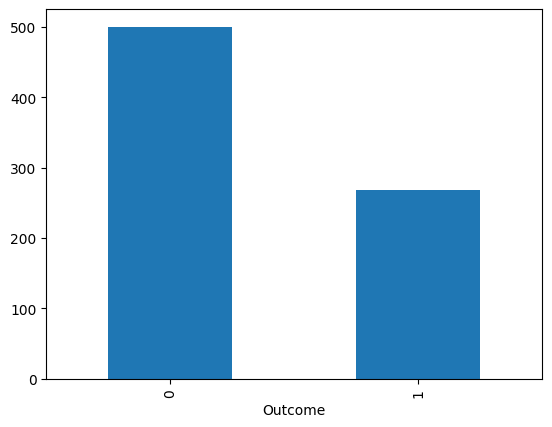

In [ ]:
df['Outcome'].value_counts().plot(kind = 'bar')

## Correlation Matrix

In [ ]:
df.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.128135,0.214178,0.100239,0.082171,0.021719,-0.033523,0.544341,0.221898
Glucose,0.128135,1.000000,0.223192,0.228043,0.581186,0.232771,0.137246,0.267136,0.494650
BloodPressure,0.214178,0.223192,1.000000,0.226839,0.098272,0.289230,-0.002805,0.330107,0.170589
SkinThickness,0.100239,0.228043,0.226839,1.000000,0.184888,0.648214,0.115016,0.166816,0.259491
Insulin,0.082171,0.581186,0.098272,0.184888,1.000000,0.228050,0.130395,0.220261,0.303454
BMI,0.021719,0.232771,0.289230,0.648214,0.228050,1.000000,0.155382,0.025841,0.313680
DiabetesPedigreeFunction,-0.033523,0.137246,-0.002805,0.115016,0.130395,0.155382,1.000000,0.033561,0.173844
Age,0.544341,0.267136,0.330107,0.166816,0.220261,0.025841,0.033561,1.000000,0.238356
Outcome,0.221898,0.494650,0.170589,0.259491,0.303454,0.313680,0.173844,0.238356,1.000000


In [ ]:
outcome = 'Outcome'
results = []
for col in df.columns:
    if col != outcome:
        valid = df[[outcome, col]].dropna()
        r, p = pearsonr(valid[outcome], valid[col])
        results.append({"Variable": col,
            "Correlation": round(r, 3),
            "p-value": round(p, 4),
            "Significant (p<0.05)": p < 0.05
        })

results_df = pd.DataFrame(results)
results_df

,Variable,Correlation,p-value,Significant (p<0.05)
0,Pregnancies,0.222,0.0,True
1,Glucose,0.495,0.0,True
2,BloodPressure,0.171,0.0,True
3,SkinThickness,0.259,0.0,True
4,Insulin,0.303,0.0,True
5,BMI,0.314,0.0,True
6,DiabetesPedigreeFunction,0.174,0.0,True
7,Age,0.238,0.0,True


We find that all variables are significantly correlated with Outcome.

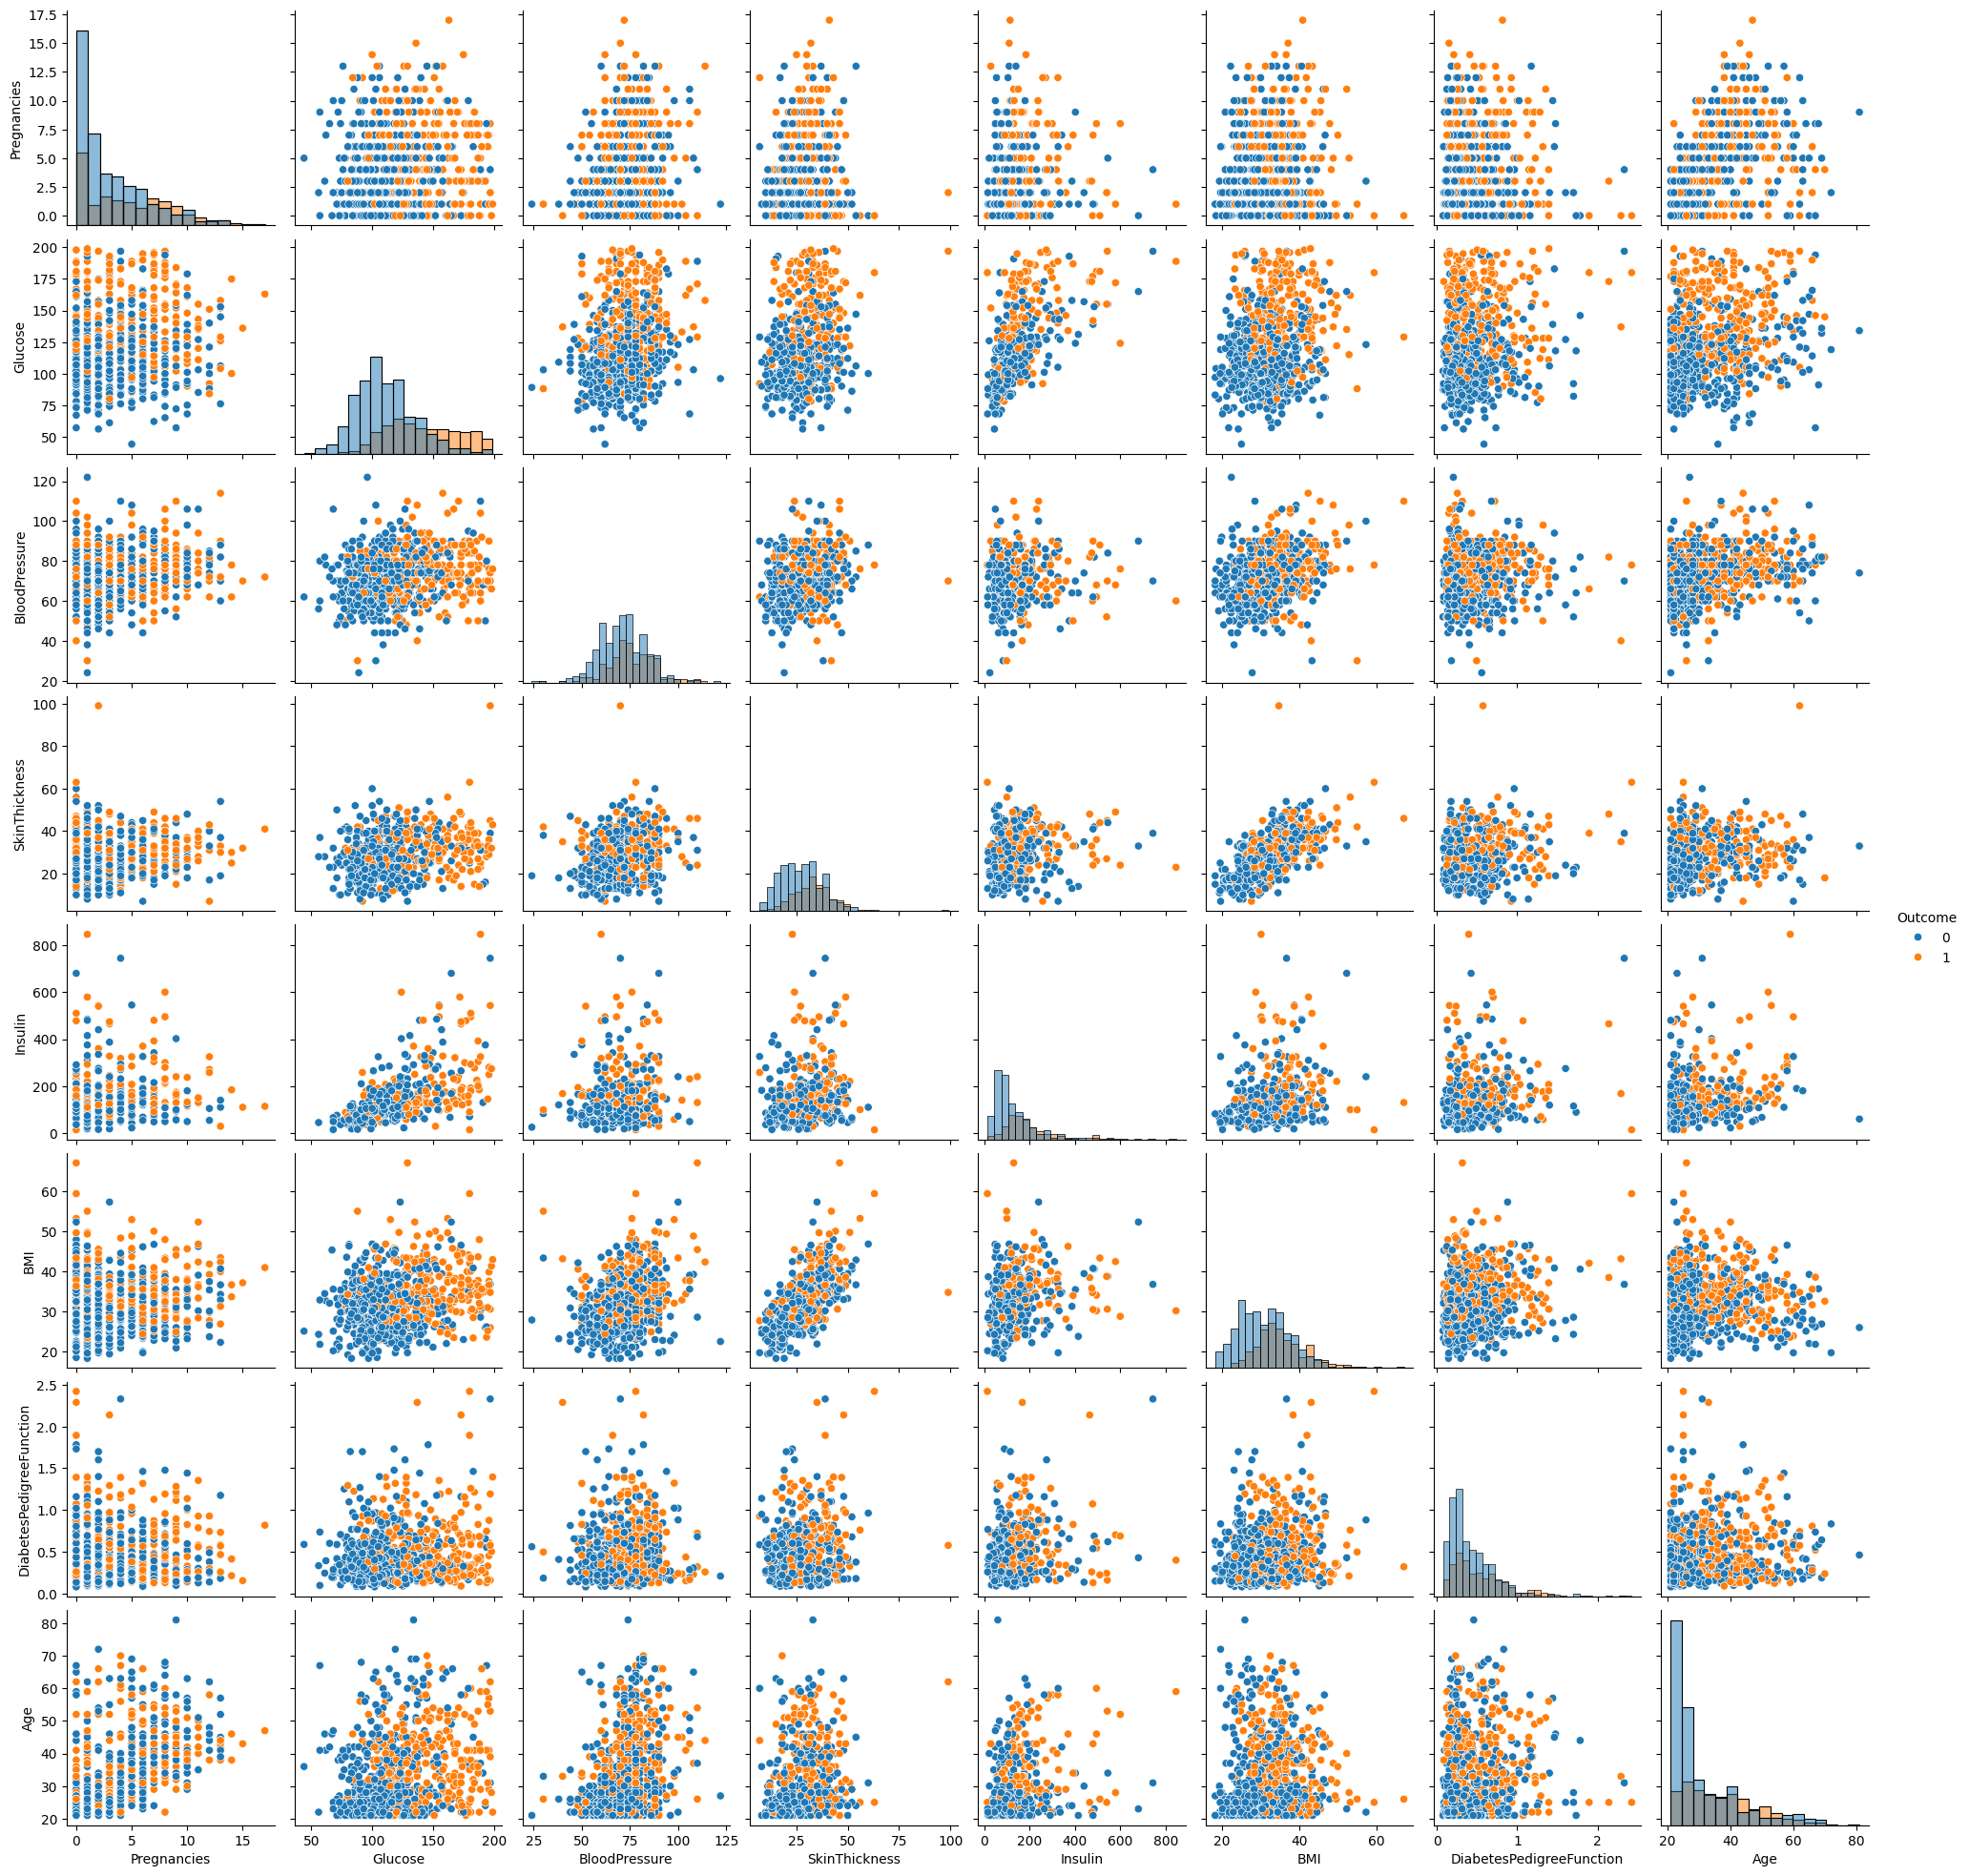

In [ ]:
sns.pairplot(df, hue = 'Outcome', diag_kind = 'hist')

## Missing Values cont.

Possible reason for high amount of missing values for insulin and skin thickness is because these factors aren't normally measured for people who aren't at risk of Diabetes. Glucose, BMI, and BP are more common factors that can help diagnose issues outside of Diabetes and therefore will likely be measured in most cases. We can check to see if whether a value is missing or not has effect on outcome.

<Axes: xlabel='Outcome', ylabel='count'>

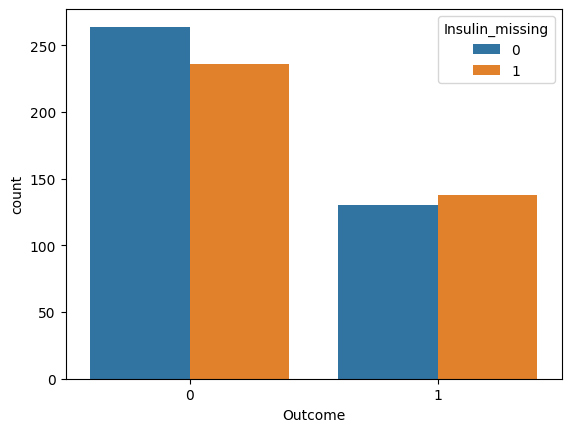

In [ ]:
df["Insulin_missing"] = df["Insulin"].isna().astype(int)
sns.countplot(x="Outcome", hue="Insulin_missing", data=df)

In [ ]:
#check for correlation
insulin_cont = pd.crosstab(df['Outcome'], df['Insulin_missing'])
chi2, p, dof, ex = stats.chi2_contingency(insulin_cont)
print(f'p-value: {p:.4f}')

p-value: 0.2898


p is 0.29 which is > 0.05 meaning Insulin_missingness is not correlated with Outcome.

<Axes: xlabel='Outcome', ylabel='count'>

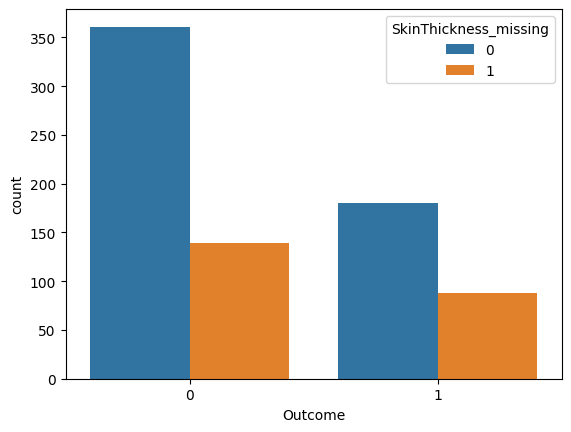

In [ ]:
df['SkinThickness_missing'] = df['SkinThickness'].isna().astype(int)
sns.countplot(x='Outcome', hue='SkinThickness_missing', data=df)

In [ ]:
skin_cont = pd.crosstab(df['Outcome'], df['SkinThickness_missing'])
chi2, p, dof, ex = stats.chi2_contingency(skin_cont)
print(f'p-value: {p:.4f}')

p-value: 0.1692


p is 0.17 which is > 0.05 meaning SkinThickness_missing is not correlated with Outcome.

Few options:

 - Drop Insulin
 - Impute median
 - Regression

Try two models with and without missing to compare and then decide.

In [ ]:
df = df.drop(columns = ['Insulin_missing', 'SkinThickness_missing'])

# Decision Tree

In [ ]:
X = df.drop(columns = ['Outcome'])
y = df['Outcome']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify = y)
results = {}

# Model 1: Drop Insulin
X_train_ModelA = X_train.drop(columns = ['Insulin'])
X_test_ModelA = X_test.drop(columns = ['Insulin'])
dtree_ModelA = DecisionTreeClassifier(max_depth=3, random_state=0)
dtree_ModelA.fit(X_train_ModelA, y_train)
y_pred_ModelA = dtree_ModelA.predict(X_test_ModelA)
results["Drop Insulin"] = (accuracy_score(y_test, y_pred_ModelA), f1_score(y_test, y_pred_ModelA))


# Model 2: Impute Median
imputer = SimpleImputer(strategy='median')
X_train_ModelB = imputer.fit_transform(X_train)
X_test_ModelB = imputer.transform(X_test)
dtree_ModelB = DecisionTreeClassifier(max_depth=3, random_state=0)
dtree_ModelB.fit(X_train_ModelB, y_train)
y_pred_ModelB = dtree_ModelB.predict(X_test_ModelB)
results["Impute Median"] = (accuracy_score(y_test, y_pred_ModelB), f1_score(y_test, y_pred_ModelB))

for k, (acc, f1) in results.items():
    print(f"{k}: Accuracy = {acc:.3f}, F1 = {f1:.3f}")

Drop Insulin: Accuracy = 0.792, F1 = 0.704
Impute Median: Accuracy = 0.792, F1 = 0.704


Accuracy and F1 are same across both models. Insulin likely has no effect on the model. We can check feature importance.

In [ ]:
#How much is Insulin affecting Decision Tree
fi = pd.Series(dtree_ModelB.feature_importances_, index=X_train.columns)
print(fi.sort_values(ascending=False))

zero_features = fi[fi == 0].index.tolist()
print("\nZero-importance features:", zero_features)

Glucose                     0.535321
BMI                         0.268310
Age                         0.138885
DiabetesPedigreeFunction    0.057485
SkinThickness               0.000000
BloodPressure               0.000000
Pregnancies                 0.000000
Insulin                     0.000000
dtype: float64

Zero-importance features: ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin']


In [ ]:
#Try model with 0 importance features dropped

X_train_reduced = X_train.drop(columns = zero_features)
X_test_reduced = X_test.drop(columns = zero_features)

dtree_reduced = DecisionTreeClassifier(max_depth=3, random_state=0)
dtree_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = dtree_reduced.predict(X_test_reduced)
acc = accuracy_score(y_test, y_pred_reduced)
f1  = f1_score(y_test, y_pred_reduced)
print(f'Accuracy: {acc:.3f}\nF1: {f1:.3f}')

Accuracy: 0.792
F1: 0.704


Accuracy and F1 did not change after dropping all zero importance features.

 Next test other depths to see which model is best.

In [ ]:
#Testing tree depth

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
results = []

for d in range(1,7):
    dtree = DecisionTreeClassifier(max_depth = d, random_state = 0)
    scores = cross_val_score(dtree, X_train_reduced, y_train, cv = cv, scoring = 'f1')
    results.append((d, scores.mean()))

for d, f1 in results:
    print(f'Depth {d}: F1 = {f1:.3f}')

best_depth, best_f1 = max(results, key=lambda x: x[1])
print(f'\nBest depth: {best_depth}\nBest F1: {best_f1:.3f} ')

Depth 1: F1 = 0.581
Depth 2: F1 = 0.572
Depth 3: F1 = 0.590
Depth 4: F1 = 0.629
Depth 5: F1 = 0.613
Depth 6: F1 = 0.578

Best depth: 4
Best F1: 0.629 


Depth of 4 returns highest F1 value.

In [ ]:
#dtree with max_depth = 4

dtree_reduced = DecisionTreeClassifier(max_depth=4, random_state=0)
dtree_reduced.fit(X_train_reduced, y_train)
y_pred_reduced = dtree_reduced.predict(X_test_reduced)
acc = accuracy_score(y_test, y_pred_reduced)
f1  = f1_score(y_test, y_pred_reduced)
print(f'Accuracy: {acc:.3f}\nF1: {f1:.3f}')

Accuracy: 0.695
F1: 0.525


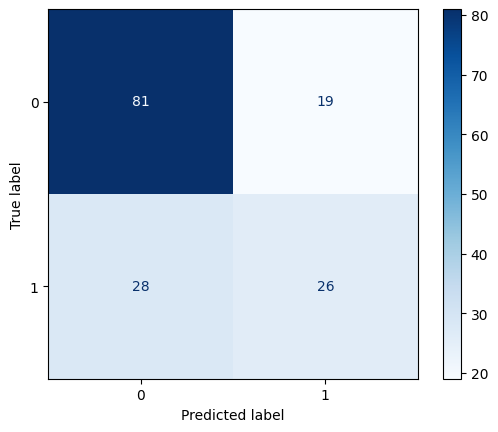

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot(cmap='Blues')

Compare with baseline naive model.

In [ ]:
#Majority Class Baseline Model
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train_reduced, y_train)
y_dummy = dummy.predict(X_test_reduced)


print(f'Accuracy: {round(accuracy_score(y_test, y_dummy), 2)}')
print(f'F1: {f1_score(y_test, y_dummy)}')

Accuracy: 0.65
F1: 0.0


Decision tree outperforms baseline majority class model.

# Random Forest

In [ ]:
# Baseline Random Forest Model

# Initialize and train the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=0, n_estimators=300)
rf_model.fit(X_train, y_train)

# Make prediction
y_pred = rf_model.predict(X_test)

# Evaluate the model's accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.2f}")

# F1-score
print(f"F1-score : {f1_score(y_test, y_pred):.3f}")


Model Accuracy: 0.81
F1-score : 0.694


In [ ]:
# Tuning hyperparameters to find optimal settings
parameter_grid = {
    "n_estimators": [100, 300, 500],
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", "log2"],
    "class_weight": [None, "balanced"]
}

rf = RandomForestClassifier(random_state=0)

grid_search = GridSearchCV(rf, parameter_grid, cv=5, scoring="f1")
grid_search.fit(X_train, y_train)

# Setting model w/ ideal params and predicting
best_model = grid_search.best_estimator_
best_f1 = grid_search.best_score_

y_pred = best_model.predict(X_test)

# Results
print("Best params:", grid_search.best_params_)
print("CV F1:", round(grid_search.best_score_, 3))
print("Accuracy:", round(accuracy_score(y_test, y_pred),3))
print("Precision:", round(precision_score(y_test, y_pred),3))
print("Recall:", round(recall_score(y_test, y_pred),3))
print("F1:", round(best_f1,3))

Best params: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
CV F1: 0.642
Accuracy: 0.792
Precision: 0.739
Recall: 0.63
F1: 0.642


Using GridSearchCV to find best parameters. Using direct predcitions (YES/NO from 50% probability threshold). Next: change threshold to see if we can get increased performance.

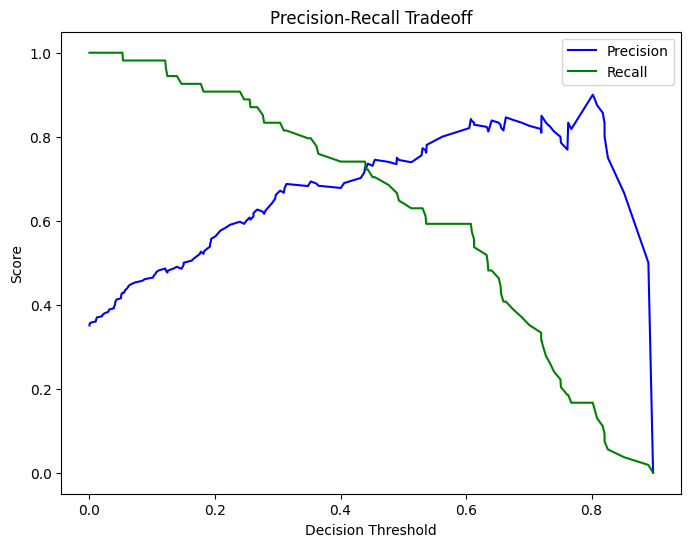

Best threshold for F1: 0.3137515671147171


In [ ]:
from sklearn.metrics import precision_recall_curve

# Probabilities for the positive class (diabetes = 1)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Get precision, recall for many thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_prob)

# Graph Precision/Recall Tradeoff Graph
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions[:-1], color="blue", label="Precision")
plt.plot(thresholds, recalls[:-1], color="green", label="Recall")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall Tradeoff")
plt.legend()
plt.show()


# Finding threshold with max F1 score
thresholds = thresholds
f1_scores = []

for t in thresholds:
    y_pred_custom = (y_prob >= t).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_custom))

best_t = thresholds[f1_scores.index(max(f1_scores))]
print("Best threshold for F1:", best_t)

In [ ]:
y_pred_custom = (y_prob >= best_t).astype(int) # Taking y_probs from best model from GridCVSearch and comparing to chosen threshold

print("Accuracy:", round(accuracy_score(y_test, y_pred_custom),3))
print("Precision:", round(precision_score(y_test, y_pred_custom),3))
print("Recall:", round(recall_score(y_test, y_pred_custom),3))
print("F1:", round(f1_score(y_test, y_pred_custom),3))

Accuracy: 0.805
Precision: 0.688
Recall: 0.815
F1: 0.746


Improved Recall compared to F1 compared to previous model. This is important for our application (Diabetes prediction) since recall is extremely important in healthcare diagnostics.

In [ ]:
# Compare RF Model to Dummy
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_dummy = dummy.predict(X_test)

# Evaluate
print("Baseline Accuracy:", round(accuracy_score(y_test, y_dummy),3))
print("Baseline F1:", f1_score(y_test, y_dummy))

Baseline Accuracy: 0.649
Baseline F1: 0.0


Confirmation that RF model outperforms dummy model.

Text(0.5, 1.0, 'Random Forest')

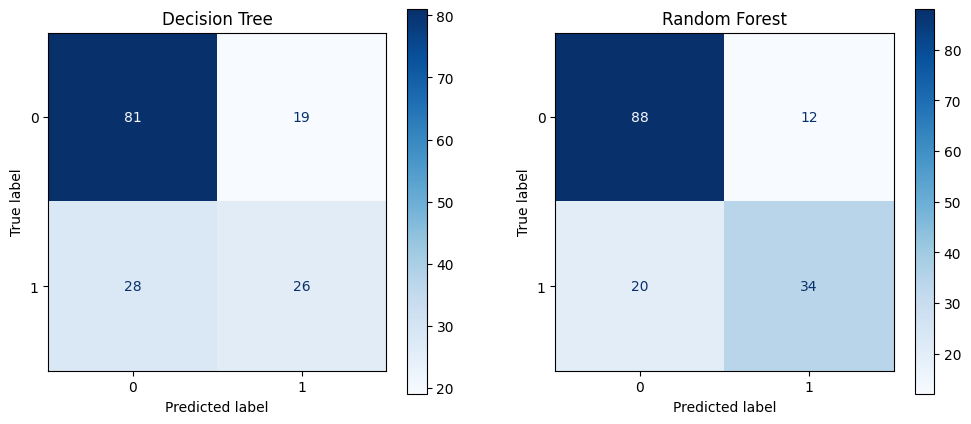

In [ ]:
#Confusion Matrices

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

cm_dt = confusion_matrix(y_test, y_pred_reduced)
ConfusionMatrixDisplay(cm_dt, display_labels=[0, 1]).plot(ax=axes[0], cmap='Blues')
axes[0].set_title("Decision Tree")

cm_rf = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm_rf, display_labels=[0,1]).plot(ax=axes[1], cmap='Blues')
axes[1].set_title("Random Forest")

Confusion Matrices show that random forest model has much better precision and recall.

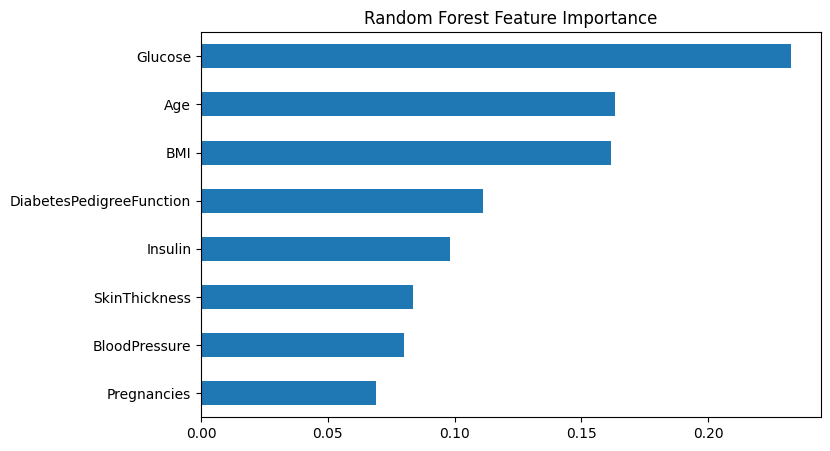

In [ ]:
feat_importance = pd.Series(best_model.feature_importances_, index=X_train.columns)
feat_importance.sort_values().plot(kind="barh", figsize=(8,5))
plt.title("Random Forest Feature Importance")
plt.show()

All features contributing to random forest model unlike decision tree.

# Support Vector Machines

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# cols w/ 0s
cols_with_zeros_as_nan = ["Glucose","BloodPressure","SkinThickness","Insulin","BMI"]


# replace 0s w/ NaN
df_clean = df.copy()
df_clean[cols_with_zeros_as_nan] = df_clean[cols_with_zeros_as_nan].replace(0, np.nan)

#fill missing values w/ median
X = df_clean.drop(columns="Outcome").fillna(df_clean.median())
y = df_clean["Outcome"]


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# pipeline: standardize features before fitting
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

In [ ]:
# param combinations for tests
param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__kernel": ["linear", "rbf", "poly"],
    "svm__gamma": ["scale", "auto"]
}

# cross-validation for each combination
grid = GridSearchCV(pipe, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Best params: {'svm__C': 0.1, 'svm__gamma': 'scale', 'svm__kernel': 'linear'}
Best CV accuracy: 0.775303212048514


              precision    recall  f1-score   support

           0       0.75      0.83      0.79       100
           1       0.60      0.48      0.54        54

    accuracy                           0.71       154
   macro avg       0.68      0.66      0.66       154
weighted avg       0.70      0.71      0.70       154



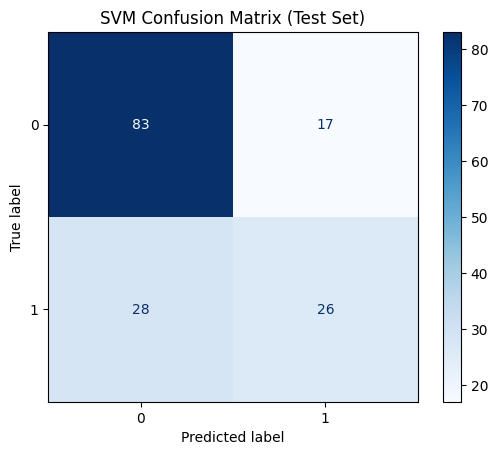

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, cmap="Blues")
plt.title("SVM Confusion Matrix (Test Set)")
plt.show()

In [ ]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# prepare data
X = df_clean.drop(columns="Outcome").fillna(df_clean.median())
y = df_clean["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# models
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (RBF, scaled)": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=1, gamma="scale"))
    ])
}

# train, predict, get scores
results = []
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).set_index("Model")
display(results_df)

,Accuracy,Precision,Recall,F1
Model,,,,
Decision Tree,0.681818,0.553191,0.481481,0.514851
Random Forest,0.779221,0.727273,0.592593,0.653061
"SVM (RBF, scaled)",0.740260,0.652174,0.555556,0.600000


The table above compares the performance of the three models covered so far: Decision Tree, Random Forest, and SVM.

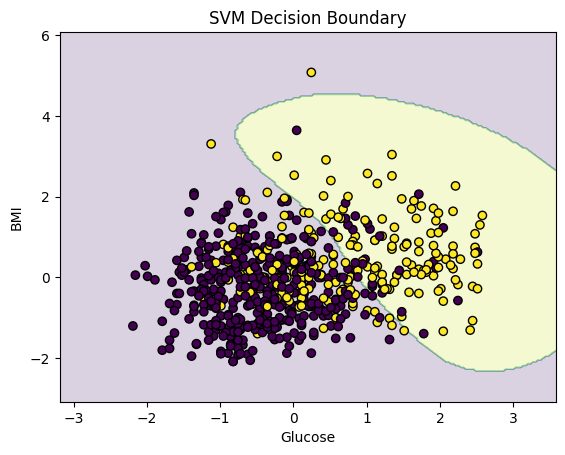

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(model, X, y, features):
    X_2d = X[features].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_2d)

    # fit model
    model.fit(X_scaled, y)
    # create grid of points covering feature space
    x_min, x_max = X_scaled[:, 0].min()-1, X_scaled[:, 0].max()+1
    y_min, y_max = X_scaled[:, 1].min()-1, X_scaled[:, 1].max()+1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))

    # predict class for each point
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # plot
    plt.contourf(xx, yy, Z, alpha=0.2)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, edgecolors="k")
    plt.xlabel(features[0]); plt.ylabel(features[1])
    plt.title("SVM Decision Boundary")
    plt.show()

plot_decision_boundary(SVC(kernel="rbf", C=grid.best_params_["svm__C"]), X_train, y_train, ["Glucose","BMI"])

2D visualization of how SVM separates classes in Glucose-BMI space.

* Shaded regions show SVM decision boundary

* Scatter points show real patient data

This helps interpret whether model is capturing meaningful separation (like higher glucose + higher BMI = more likely diabetic).

# K-Means Clustering

Imports

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt

Drop Outcome column to get rid of labels in unsupervised learning. Handle NaNs

In [ ]:
feature_cols = [c for c in df.columns if c != 'Outcome']
x = df[feature_cols].copy()
y = df['Outcome'].copy()

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
x_imputed = imputer.fit_transform(x)
x_scaled = scaler.fit_transform(x_imputed)

Try different k values

In [ ]:
ks = [2, 3, 4, 5, 6]
inertias, silhouettes = [], []

for k in ks:
  km = KMeans(n_clusters=k, n_init=10, random_state=42)
  labels = km.fit_predict(x_scaled)
  inertias.append(km.inertia_)
  silhouettes.append(silhouette_score(x_scaled, km.labels_))

best_k = ks[int(np.argmax(silhouettes))]
print("Silhouette Scores: ", dict(zip(ks, [round(s,4) for s in silhouettes])))
print("Chosen k: ", best_k)

NameError: name 'KMeans' is not defined

Fit final KMeans

In [ ]:
kmeans = KMeans(n_clusters=best_k, n_init=25, random_state=42)
cluster_labels = kmeans.fit_predict(x_scaled)

df_kmeans = df.copy()
df_kmeans['cluster'] = cluster_labels

Visualization

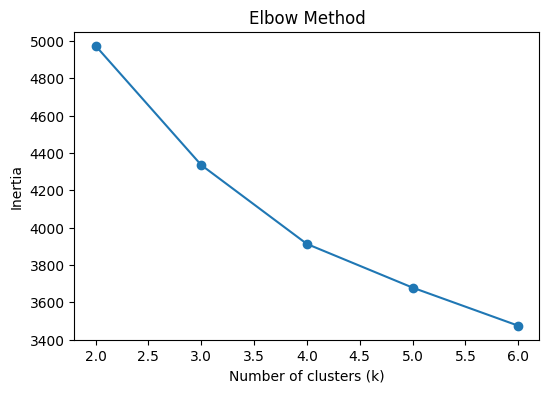

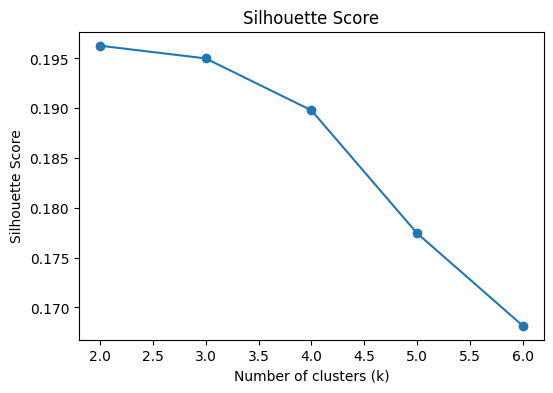

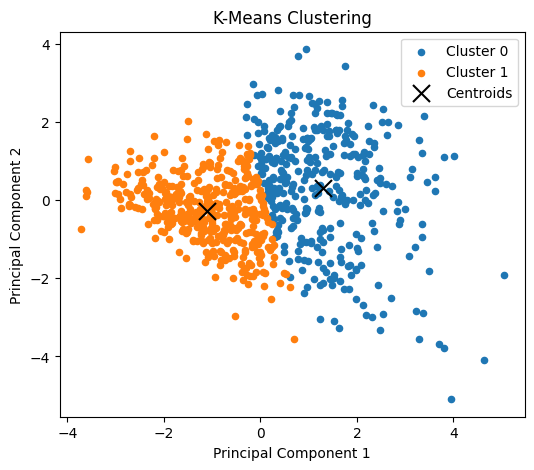

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(ks, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

plt.figure(figsize=(6,4))
plt.plot(ks, silhouettes, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score')
plt.show()

pca = PCA(n_components=2, random_state=42)
x_pca = pca.fit_transform(x_scaled)
plt.figure(figsize=(6,5))
for c in range(best_k):
  mask = cluster_labels == c
  plt.scatter(x_pca[mask, 0], x_pca[mask, 1], s=20, label=f'Cluster {c}')
plt.scatter(
    pca.transform(kmeans.cluster_centers_)[:, 0],
    pca.transform(kmeans.cluster_centers_)[:, 1],
    marker='x', s=150, c='black', label='Centroids'
)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-Means Clustering')
plt.legend()
plt.show()

Evaluate vs Outcome

In [ ]:
ct = pd.crosstab(df_kmeans['cluster'], y, rownames=['Cluster'], colnames=['Outcome'])
purity = (ct.max(axis=1).sum()) / ct.to_numpy().sum()
ari = adjusted_rand_score(y, cluster_labels)

print("Cluster vs Outcome table:")
print(ct)
print(f"Purity: {round(purity, 4)}")
print(f"ARI: {round(ari, 4)}")

Cluster vs Outcome table:
Outcome    0    1
Cluster          
0        158  195
1        342   73
Purity: 0.6992
ARI: 0.1573


Inspect centroids in original scale

In [ ]:
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=x.columns)
centroids_df['cluster'] = range(best_k)
print("\nCentroids in original scale:")
print(centroids_df)


Centroids in original scale:
   Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
0     5.754237  137.864407      78.920904      32.711864  168.502825   
1     2.212560  107.797101      66.799517      26.026570  116.874396   

         BMI  DiabetesPedigreeFunction        Age  cluster  
0  35.262712                  0.503644  40.985876        0  
1  30.054589                  0.444713  26.618357        1  
